In [1]:
#Imports and Settings
import pandas as pd
import numpy as np
import swifter
import matplotlib.pyplot as plt
import glob
import os
from datetime import datetime
from operator import mul
import seaborn as sn
import random

#Modeling
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, 
f1_score, accuracy_score, precision_score, recall_score)
from sklearn.preprocessing import StandardScaler

#Helper Functions
from helper import predict, confusion_matrix1, calculate_threshold_values, plot_roc
#Pandas Settings to Display Rows and Cols
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', None) 
pd.set_option('display.max_rows', 10) 

#Matplotlib Style Settings
plt.style.use('fivethirtyeight')
params = {'legend.fontsize': 'large',
          'figure.figsize': (15, 10),
         'axes.labelsize': 'large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)

#Pandas Standaridzer for Float Formatting
#pd.options.display.float_format = '{:,.2f}'.format
#pd.reset_option('display.float_format')

import warnings
warnings.filterwarnings("ignore")

from tqdm.auto import tqdm
tqdm.pandas(desc="my bar!")

In [2]:
# Looping through data folder to concat CSV's into one big dataframe
# 1002400 rows in dataset
# 63 columns
# Reinitialize HERE

for i,name in tqdm(enumerate(glob.glob('data/CSV/*'))):
    if i == 0:
        df = pd.read_csv(name)
    df2 = pd.read_csv(name)
    concat = pd.concat([df,df2],ignore_index=True)
    df = concat

In [3]:
#Back Up Reinitilization 
data = df.copy()

In [4]:
# Reinitilize DF
%time df = data.copy()

CPU times: user 302 ms, sys: 361 ms, total: 663 ms
Wall time: 661 ms


In [5]:
data.head(1)

,M,LA_No,T_No,Classics_Request_ID,End_Of_Run,Start_Date,First_Date,Last_Date,Play_Dates,FRM,Release,Local,Media_Formats,Rental_Measure,Theatre,Status,Boxoffice,Boxoffice_Net,Film_Rental,To_Receive,Admissions,FRM_Perc,Terms_Perc,Price,Min_Max,MG_FF,Office,Customer_Reference,Film_Buyer,Buying_Circuit,Payer,Remark,Payer_Remark,DType,Aspect_Ratio,Sound_System,Seat_Type,Amenity,Frame_Rate,Resolution,Projection_Type,Licensor,L,Hire,Rem_,Rem_Date,Show,Media_Type,Dim_,LV,Division,Branch,TV_Market,Area,Circuit,City,Seeks_Run,No,Usage,VPF_Company,Sales,Screen,NENR
0,-,00081065-01,1,NaN,n,3/16/2018 00:00:00,3/16/2018 00:00:00,3/18/2018 00:00:00,03/16;03/17;03/18,ff,"LEGO NINJAGO MOVIE, THE",2066081.0,ENG.2.DIG.0.0.0.0,none,MARCUS ST. CLAIR 10,Approved,0.0,0.0,175.0,175.0,0,0.0,-,0,-,175.0,ENCINO OFFICE,NaN,"Kuhlman, Nicole",MARCUS THEATRES,MARCUS THEATRES,NaN,NaN,no,no,no,none,none,none,none,none,None,NaN,0.0,0.0,1/1/1950 00:00:00,Normal,no,-,non,EASTERN,ST. LOUIS,ST LOUIS,"ST. LOUIS, MO",MARCUS THEATRES,"FAIRVIEW HEIGHTS, IL",OTHER - Temp Close,( 1 ),1.0,Cinedigm 2,sgoyette,MARCUS ST. CLAIR 10,NaN


In [6]:
#Trimming off extraneous columns
df = df.iloc[:,1:57]
df = df.drop(['Classics_Request_ID','End_Of_Run','Play_Dates','Start_Date','Local','Rental_Measure','Boxoffice_Net',
              'Film_Rental','To_Receive','FRM_Perc','Min_Max','MG_FF','Price','Customer_Reference','Office',
             'Remark','Payer_Remark','DType','Aspect_Ratio','Sound_System','Seat_Type','Amenity','Frame_Rate',
             'Resolution','Projection_Type','Licensor','L','Hire','Rem_','Rem_Date','Media_Type','Dim_','LV','Circuit'],axis=1)
#Data Leakage
#df = df.drop('Admissions',axis=1)
df.head(2)

,LA_No,T_No,First_Date,Last_Date,FRM,Release,Media_Formats,Theatre,Status,Boxoffice,Admissions,Terms_Perc,Film_Buyer,Buying_Circuit,Payer,Show,Division,Branch,TV_Market,Area,City,Seeks_Run
0,00081065-01,1,3/16/2018 00:00:00,3/18/2018 00:00:00,ff,"LEGO NINJAGO MOVIE, THE",ENG.2.DIG.0.0.0.0,MARCUS ST. CLAIR 10,Approved,0.0,0,-,"Kuhlman, Nicole",MARCUS THEATRES,MARCUS THEATRES,Normal,EASTERN,ST. LOUIS,ST LOUIS,"ST. LOUIS, MO","FAIRVIEW HEIGHTS, IL",OTHER - Temp Close
1,00085822-14,14,2/24/2018 00:00:00,2/24/2018 00:00:00,sp,"LEGO NINJAGO MOVIE, THE",ENG.2.DIG.0.0.0.0,KINGSWAY 2,Returns In,0.0,0,35,"PEREIRA, RUI",7061412 CANADA LTD,7061412 CANADA LTD,Normal,CANADIAN,TORONTO,TORONTO,"TORONTO, ON","TORONTO, ON #1 TORONTO, ON",LATE - Temp Close


In [7]:
#Drop any duplicate ID's
df.drop_duplicates('LA_No',inplace=True)

#Dropping any non SP payments
df = df[df['FRM']=='sp'] 

# Only looking at records with grosses returned
df = df[df['Status']=='Returns In']

df = df[df.Division != 'CLASSICS']

#Dropping 500 NAN media formats
df = df.dropna(axis=0)

#Not in YT Data
df = df[df.Release !='THEY SHALL NOT GROW OLD']
df = df[df.Release !='FANTASTIC BEASTS AND WHERE TO FIND THEM']

In [8]:
df['First_Date'] = pd.to_datetime(df['First_Date'])
df['Last_Date'] = pd.to_datetime(df['Last_Date'])

df['Boxoffice'] = df['Boxoffice'].astype(str)
df['Boxoffice'] = df['Boxoffice'].apply(lambda x: x.replace(',', ''))
df['Boxoffice'] = df['Boxoffice'].astype(float)
df['T_No'] = df['T_No'].astype(float)

# Removed Admissions because of data leakage
df['Admissions'] = df['Admissions'].astype(str)
df['Admissions'] = df['Admissions'].apply(lambda x: x.replace(',', ''))
df['Admissions'] = df['Admissions'].astype(float)


In [9]:
def format_assign(x):
    if 'IMAX' in x or 'IXD'in x or 'DIMX' in x:     
        return 'IMAX'
    if 'PLF' in x or 'PLD' in x:
        return 'PLF'
    elif '3D' in x:
        return '3D'
    else:
        return '2D'

def seeks_run(x):
    if 'FIRST' in x:
        return 'FIRST RUN'
    elif 'LATE' in x:
        return 'LATE RUN'
    elif 'SUB' in x:
        return 'SUB RUN'
    else:
        return 'OTHER'
    # Intermediate Run, Other-Temp Close, IMAX, Art House, Calendar, Classics

df['Media_Formats'] = df['Media_Formats'].astype(str)
df['Media_Formats'] = df['Media_Formats'].swifter.apply(format_assign)
df['Seeks_Run'] = df['Seeks_Run'].swifter.apply(seeks_run)

# Anonymizing Data

In [10]:
from faker import Faker

In [11]:
# Number of values to annoymize
# 6022 Theatres
# 4661 Film Buyer/Buying Circuit/Payer
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(df[['Theatre','Film_Buyer','Buying_Circuit','Payer']].nunique())

Theatre           6001
Film_Buyer        1044
Buying_Circuit     795
Payer             2789
dtype: int64


In [12]:
confid_users = list(df.Payer.unique())
confid_users.extend(list(df.Buying_Circuit.unique()))
confid_users.extend(list(df.Film_Buyer.unique()))

In [13]:
distinct_confid = set(confid_users)

In [14]:
Faker.seed(2)
fake = Faker()
fake_names = []
for _ in tqdm(range(5300)):
    fake_names.append(fake.company())
fake_names = set(fake_names)
fake_names = list(fake_names)

In [15]:
confid_dict = dict.fromkeys(distinct_confid)
for key,value in tqdm(confid_dict.items()):
    confid_dict[key] = random.sample(fake_names,1)[0]

In [16]:
cinema_names = pd.read_csv('data/extra_data/Cinema_names.csv',header=None)

In [17]:
cinema_names;

In [18]:
cinema_list = []
for n in tqdm(range(0,674)):
    if len(cinema_names[0].apply(lambda x: x.split(' '))[n])>1:
        cinema_list.append(cinema_names[0].apply(lambda x: x.split(' '))[n][1])
    else:
        continue

In [19]:
suffixes = ['Theaters','Cinemas','Movies','Flicks','Screens','Forum','Marquee']
maccs_theatres = df['Theatre'].unique().tolist()
maccs_theatres_dict = dict.fromkeys(maccs_theatres)


In [20]:
for key,value in maccs_theatres_dict.items():
    maccs_theatres_dict[key] = random.choice(cinema_list) +' '+ random.choice(cinema_list) + ' '+ random.choice(suffixes) 

maccs_theatres_dict

{'KINGSWAY 2': 'Perch Inside Cinemas',
 'CANYON MEADOWS 10': 'Blueprint Jackpot Flicks',
 'RAINBOW 8 ': 'Made Best Forum',
 'MARCUS SHOWTIME 12': 'Champion Joint Marquee',
 'BLUE RIDGE 14': 'Daub Spirit Cinemas',
 'CINEMARK MOVIES 16': 'Marks Grand Movies',
 'PICTURE SHOW 8': 'Cerberus Enjoy Theaters',
 'WESTWOOD CINEMA 8': 'Mungo Days Theaters',
 'MARCUS ST. CLAIR 10': 'Guava Azure Movies',
 'MOVIES 10': 'Buys Max Movies',
 'MASTERS 7': 'Brig Cavil Marquee',
 'HOLLYWOOD USA 15': 'Preview for Cinemas',
 'NASA 8': 'Jam Ride Flicks',
 'SUPER SAVER CINEMAS 6': 'Perfect Quad Marquee',
 'PICTURE SHOW 8 @ SUPERSTITION SPRINGS': 'Handbook Bliss Theaters',
 'PALACE W CINEMA 8': 'Mungo Phalanx Theaters',
 'MOVIES 12': 'Incredible Den Screens',
 'MOVIES 9': 'Plus Archives Cinemas',
 'COTTONWOOD 4': 'Offers Blink Flicks',
 'HOLLYWOOD SURREY 3': 'Click Dept Movies',
 'W BOYLSTON CINEMA 5': 'Mixer Comparison Cinemas',
 'PICTURE SHOW 6': 'Comparison Froe Marquee',
 'COVENTRY 13': 'Fusion Capital Cin

In [21]:
%time df['Theatre'].replace(maccs_theatres_dict,inplace=True)
%time df['Buying_Circuit'].replace(confid_dict,inplace=True)
%time df['Film_Buyer'].replace(confid_dict,inplace=True)
%time df['Payer'].replace(confid_dict,inplace=True)

CPU times: user 3min 8s, sys: 3.44 s, total: 3min 12s
Wall time: 3min 12s
CPU times: user 1min 12s, sys: 2.03 s, total: 1min 14s
Wall time: 1min 14s
CPU times: user 1min 12s, sys: 2.05 s, total: 1min 14s
Wall time: 1min 14s
CPU times: user 1min 22s, sys: 2.02 s, total: 1min 24s
Wall time: 1min 24s


In [44]:
#Only opening week
ow_df = df[df['Seeks_Run']=='FIRST RUN'].sort_values(['Theatre','Release','T_No'])
ow_df = ow_df[ow_df['T_No']==1]
ow_df.reset_index(inplace=True)
ow_df.drop(['index','FRM','LA_No','Status','Last_Date','Terms_Perc','Branch','Area'],axis=1,inplace=True)


ow_df

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run
0,1.0,2018-01-18,12 STRONG,2D,About Archive Forum,1025.17,144.0,Reyes-Salazar,Wheeler-Smith,Wheeler-Smith,Normal,SOUTHERN,RALEIGH-DURHAM,"DURHAM, NC",FIRST RUN
1,1.0,2018-02-09,"15:17 TO PARIS, THE",2D,About Archive Forum,1780.70,223.0,Reyes-Salazar,Wheeler-Smith,Wheeler-Smith,Normal,SOUTHERN,RALEIGH-DURHAM,"DURHAM, NC",FIRST RUN
2,1.0,2019-06-25,ANNABELLE COMES HOME,2D,About Archive Forum,4018.40,470.0,"Ryan, Keith and Eaton",Wheeler-Smith,Wheeler-Smith,Normal,SOUTHERN,RALEIGH-DURHAM,"DURHAM, NC",FIRST RUN
3,1.0,2017-08-10,ANNABELLE: CREATION,2D,About Archive Forum,3689.09,416.0,"Kelley, Ray and Prince",Wheeler-Smith,Wheeler-Smith,Normal,SOUTHERN,RALEIGH-DURHAM,"DURHAM, NC",FIRST RUN
4,1.0,2018-12-20,AQUAMAN (2018),2D,About Archive Forum,10602.81,1201.0,"Ryan, Keith and Eaton",Wheeler-Smith,Wheeler-Smith,Normal,SOUTHERN,RALEIGH-DURHAM,"DURHAM, NC",FIRST RUN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205419,1.0,2018-10-04,"STAR IS BORN, A (2024779)",2D,for Shadow Marquee,2877.24,717.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN
205420,1.0,2018-06-14,TAG (2018),2D,for Shadow Marquee,2171.21,495.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN
205421,1.0,2018-07-26,TEEN TITANS GO! TO THE MOVIES,2D,for Shadow Marquee,1400.75,402.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN
205422,1.0,2018-03-15,TOMB RAIDER,2D,for Shadow Marquee,2214.50,500.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN


In [45]:
#Total Opening Week Numbers
#with pd.option_context('display.float_format','{:,.2f}'):
ow_bo = ow_df.groupby('Release').sum()['Boxoffice']
ow_bo = ow_bo.astype(int)
ow_bo = ow_bo.reset_index()
ow_bo['Boxoffice_Total'] = ow_bo['Boxoffice']
ow_bo.drop('Boxoffice',axis=1,inplace=True)

ow_bo

,Release,Boxoffice_Total
0,12 STRONG,19892950
1,"15:17 TO PARIS, THE",17744384
2,ANNABELLE COMES HOME,39301786
3,ANNABELLE: CREATION,45340847
4,AQUAMAN (2018),119892164
...,...,...
49,TAG (2018),22798241
50,TEEN TITANS GO! TO THE MOVIES,16205368
51,TOMB RAIDER,27926483
52,UNFORGETTABLE,6497468


# Opening Weekend DataFrame

In [46]:
ow_data = ow_df.merge(ow_bo,how='left',left_on='Release',right_on='Release')
#ow_data['perc_of_bo'] = (ow_data.Boxoffice/ow_data.Boxoffice_Total).astype(float)
#ow_data['perc_of_bo'] = round(ow_data['perc_of_bo'],5)
ow_data.head(1)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total
0,1.0,2018-01-18,12 STRONG,2D,About Archive Forum,1025.17,144.0,Reyes-Salazar,Wheeler-Smith,Wheeler-Smith,Normal,SOUTHERN,RALEIGH-DURHAM,"DURHAM, NC",FIRST RUN,19892950


# Baseline with average of entire data set, of all movies, all theatres, first 3 weeks

In [47]:
'''
ow_data['over_index'] = ow_data['perc_of_bo']-ow_data.describe()['perc_of_bo'].loc['mean']
ow_data['over_index'] = ow_data['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_data = ow_data[ow_data['T_No']==1]
ow_data = ow_data[ow_data['Seeks_Run'] == 'FIRST RUN']
ow_data.head()
'''

"\now_data['over_index'] = ow_data['perc_of_bo']-ow_data.describe()['perc_of_bo'].loc['mean']\now_data['over_index'] = ow_data['over_index'].apply(lambda x: 1 if x > 0 else 0)\now_data = ow_data[ow_data['T_No']==1]\now_data = ow_data[ow_data['Seeks_Run'] == 'FIRST RUN']\now_data.head()\n"

In [48]:
#ow_data['over_index'].value_counts()

In [49]:
#ow_data.groupby('Release')['over_index'].value_counts()


# TMDb Movie Data

In [50]:
wb_list = df['Release'].unique().tolist()
wb_list

['LEGO NINJAGO MOVIE, THE',
 'TEEN TITANS GO! TO THE MOVIES',
 'IT (2017)',
 "ISN'T IT ROMANTIC",
 '15:17 TO PARIS, THE',
 'PADDINGTON 2',
 'SUN IS ALSO A STAR, THE',
 'KING ARTHUR: LEGEND OF THE SWORD',
 'EVERYTHING, EVERYTHING',
 'RAMPAGE (2018)',
 'LIFE OF THE PARTY',
 'JOKER',
 'SMALLFOOT',
 'READY PLAYER ONE',
 'IT CHAPTER TWO',
 'JUSTICE LEAGUE (2017)',
 'CHIPS (2017)',
 'TAG (2018)',
 'CRAZY RICH ASIANS',
 'HOUSE, THE (2017)',
 'SHAZAM! (2019)',
 'NUN, THE',
 '12 STRONG',
 'SHAFT (2074539)',
 'DUNKIRK (2017)',
 'RICHARD JEWELL',
 'DOCTOR SLEEP (2019)',
 'UNFORGETTABLE',
 'GAME NIGHT',
 'CURSE OF LA LLORONA, THE',
 'GOLDFINCH, THE',
 'STAR IS BORN, A (2024779)',
 'FATHER FIGURES',
 'TOMB RAIDER',
 'KITCHEN, THE',
 'MEG, THE',
 'FIST FIGHT',
 'LEGO BATMAN MOVIE, THE',
 'BLINDED BY THE LIGHT (2083623)',
 "OCEAN'S 8",
 'WONDER WOMAN',
 'POKEMON DETECTIVE PIKACHU',
 'MULE, THE',
 'GOOD LIAR, THE',
 'AQUAMAN (2018)',
 'LEGO MOVIE 2, THE: THE SECOND PART',
 'MOTHERLESS BROOKLYN',
 'GEO

In [51]:
clean = []
for title in wb_list:
    save = title.split("(")
    clean.append(save[0])

In [52]:
clean;

In [53]:
import difflib
import itertools
def get_close_matches_icase(word, possibilities, *args, **kwargs):
    """ Case-insensitive version of difflib.get_close_matches """
    lword = word.lower()
    lpos = {}
    for p in possibilities:
        if p.lower() not in lpos:
            lpos[p.lower()] = [p]
        else:
            lpos[p.lower()].append(p)
    lmatches = difflib.get_close_matches(lword, lpos.keys(), *args, **kwargs)
    ret = [lpos[m] for m in lmatches]
    ret = itertools.chain.from_iterable(ret)
    return set(ret)

In [54]:
genre_df = pd.read_csv('data/extra_data/wb_df.csv')
genre_df['title'] = genre_df['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("{'",''))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("'}",''))

#Matching between TMDb and WB
genre_df.at[9,'title'] = "HOUSE, THE"
genre_df.at[29,'title'] = "MEG, THE"
genre_df.at[31,'title'] = "NUN, THE"
genre_df.at[35,'title'] = "MULE, THE"
genre_df.at[44,'title'] = "SHAFT (2074539)"
genre_df = genre_df[genre_df.title !='They Shall Not Grow Old']
genre_df['title'] = genre_df['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("{'",''))
genre_df['title'] = genre_df['title'].apply(lambda x: x.replace("'}",''))
genre_df.at[12,'title'] = "IT (2017)"
genre_df.at[38,'title'] = "ISN'T IT ROMANTIC"
genre_df.at[27,'title'] = "OCEAN'S 8"

genre_df = genre_df.drop(['genre_ids','Unnamed: 0','adult','id','original_language','popularity','video','vote_average','vote_count'],axis=1)
# Adding OW field
genre_df = genre_df.merge(ow_bo,how='left',left_on='title',right_on='Release')

#with pd.option_context("display.max_rows", 1000):
#    display(genre_df)

In [55]:

# Adding Comp Library Fields
comp_library = pd.read_csv('data/Comparison Library - Test.xlsx - Database.csv')
comp_library = comp_library[['TITLE','Dist','# of Runs','Genre','Rating','Season','WIDE                --------              Open Date']]
comp_library = comp_library[comp_library['Dist']=='WB']

comp_library['release_date'] = pd.to_datetime(comp_library['WIDE                --------              Open Date'])
comp_library.drop('WIDE                --------              Open Date',axis=1,inplace=True)
comp_library['year'] = comp_library['release_date'].dt.year
comp_library = comp_library[comp_library['year']>=2017]
comp_library = comp_library[comp_library['year']<2020]

comp_library['title'] = comp_library['TITLE'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.3)))
comp_library['title'] = comp_library['title'].apply(lambda x: x.replace("{'",''))
comp_library['title'] = comp_library['title'].apply(lambda x: x.replace("'}",''))


comp_library.drop(index=[90,124,132,133,231,254,259,269,279,291,300,406,421,450,638],axis=0,inplace=True)
comp_library.at[188,'TITLE'] = 'SHAFT (2074539)'
comp_library.at[188,'title'] = 'SHAFT (2074539)'
comp_library.at[248,'title'] = "ISN'T IT ROMANTIC"
comp_library.at[396,'title'] = "OCEAN'S 8"

#with pd.option_context("display.max_rows", 1000):
#    display(comp_library)

In [56]:
genre_df = comp_library.merge(genre_df,how='right',left_on='title',right_on='title',suffixes=('_x','_y'))
#Dropping TSNGO from Movie Description
genre_df.drop(36,axis=0,inplace=True)
genre_df.reset_index(inplace=True)
genre_df.drop('index',axis=1,inplace=True)
genre_df['# of Runs'] = genre_df['# of Runs'].apply(lambda x: x.replace(',',''))
genre_df['# of Runs'] = genre_df['# of Runs'].astype(int)

#Save Overview for NLP
movie_text = genre_df['overview']

genre_df.drop(['overview','release_date_x','release_date_y','Release','revenue'],axis=1,inplace=True)
genre_df.at[32,'budget'] = 80000000 #Smallfoot
genre_df.at[41,'budget'] = 9000000 #Sun is also a Star
genre_df.at[46,'budget'] = 15000000 #Blinded by the Light
#genre_df.at[11,'budget'] = 30000000 #Shaft

#with pd.option_context("display.max_rows", 1000):
#    display(genre_df)

In [57]:
genre_df

,TITLE,Dist,# of Runs,Genre,Rating,Season,year,title,budget,runtime,Boxoffice_Total
0,Chips,WB,2464,Comedy,R,Spring,2017,CHIPS (2017),25000000,100,10467132
1,Lego Batman Movie - 3D/IMAX,WB,4088,Animation,PG,Winter,2017,"LEGO BATMAN MOVIE, THE",80000000,104,56793423
2,Fist Fight,WB,3185,Comedy,R,Winter,2017,FIST FIGHT,22000000,91,16779504
3,Unforgettable,WB,2417,Suspense/Thrill,R,Spring,2017,UNFORGETTABLE,12000000,100,6497468
4,Kong: Skull Island - 3D/IMAX,WB,3846,Action/Adventure,PG13,Spring,2017,KONG: SKULL ISLAND,185000000,118,72932544
...,...,...,...,...,...,...,...,...,...,...,...
49,Joker - IMAX,WB,4374,Drama,R,Fall,2019,JOKER,55000000,122,123730399
50,Doctor Sleep,WB,3855,Horror,R,Thanksgiving,2019,DOCTOR SLEEP (2019),45000000,152,17133477
51,Motherless Brooklyn,WB,1342,Drama,R,Thanksgiving,2019,MOTHERLESS BROOKLYN,26000000,145,5165694
52,Good Liar,WB,2439,Drama,R,Thanksgiving,2019,"GOOD LIAR, THE",10000000,109,8468042


In [140]:
theatre_genre = ow_data.copy()
theatre_genre = theatre_genre.merge(genre_df[['title','Genre']], how='left',left_on='Release',right_on='title')
theatre_genre = round(theatre_genre.groupby(['Theatre','Genre'],as_index=False)['Boxoffice'].mean())

In [141]:
theatre_genre

,Theatre,Genre,Boxoffice
0,About Archive Forum,Action/Adventure,6436.0
1,About Archive Forum,Animation,3305.0
2,About Archive Forum,Children/Family,2145.0
3,About Archive Forum,Comedy,2626.0
4,About Archive Forum,Drama,3282.0
...,...,...,...
39361,for Shadow Marquee,Comedy,3018.0
39362,for Shadow Marquee,Drama,3860.0
39363,for Shadow Marquee,Horror,5990.0
39364,for Shadow Marquee,Romantic Comedy,1672.0


In [60]:
theatre_avg = ow_data.copy()
theatre_avg = theatre_avg.merge(genre_df['title'], how='left',left_on='Release',right_on='title')
theatre_avg = round(theatre_avg.groupby('Theatre',as_index=False)['Boxoffice'].mean())
theatre_avg

,Theatre,Boxoffice
0,About Archive Forum,4512.0
1,About Bevy Flicks,1196.0
2,About Bold Forum,19408.0
3,About Crypt Flicks,1797.0
4,About How Theaters,12956.0
...,...,...
4593,for Promotions Flicks,29648.0
4594,for Pure Cinemas,3073.0
4595,for Radical Theaters,1462.0
4596,for Ratchet Marquee,12673.0


In [39]:
round(genre_df.pivot_table(values='Boxoffice_Total',index=['Genre'],aggfunc='mean'))

,Boxoffice_Total
Genre,
Action/Adventure,61418906.0
Animation,32180193.0
Children/Family,16329512.0
Comedy,21089415.0
Drama,29253646.0
Horror,62678954.0
Romantic Comedy,39272324.0
Romantic Drama,9591490.0
Sci-Fi/Fantasy,46983890.0


In [61]:
genre_avg = ow_data.copy()
genre_avg = genre_avg.merge(genre_df[['Genre','title']], how='left',left_on='Release',right_on='title')
genre_avg = genre_avg.groupby(['Genre'],as_index=False)['Boxoffice'].mean()
genre_avg

,Genre,Boxoffice
0,Action/Adventure,14388.873392
1,Animation,7923.813965
2,Children/Family,4392.015134
3,Comedy,6126.013828
4,Drama,8270.283450
5,Horror,15646.827127
6,Romantic Comedy,9859.986026
7,Romantic Drama,3835.829130
8,Sci-Fi/Fantasy,11228.077658
9,Suspense/Thrill,2634.820969


In [62]:
ow_genreavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_genreavg = ow_genreavg.merge(genre_avg,how='left',on='Genre',suffixes=['_loc','_avg'])

ow_genreavg['over_index'] = ow_genreavg['Boxoffice_loc']-ow_genreavg['Boxoffice_avg']
ow_genreavg['over_index'] = ow_genreavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_genreavg.tail(5)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total,title,Genre,Boxoffice_avg,over_index
205419,1.0,2018-10-04,"STAR IS BORN, A (2024779)",2D,for Shadow Marquee,2877.24,717.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,70240763,"STAR IS BORN, A (2024779)",Drama,8270.283450,0
205420,1.0,2018-06-14,TAG (2018),2D,for Shadow Marquee,2171.21,495.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,22798241,TAG (2018),Comedy,6126.013828,0
205421,1.0,2018-07-26,TEEN TITANS GO! TO THE MOVIES,2D,for Shadow Marquee,1400.75,402.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,16205368,TEEN TITANS GO! TO THE MOVIES,Animation,7923.813965,0
205422,1.0,2018-03-15,TOMB RAIDER,2D,for Shadow Marquee,2214.50,500.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,27926483,TOMB RAIDER,Action/Adventure,14388.873392,0
205423,1.0,2017-06-01,WONDER WOMAN,2D,for Shadow Marquee,8022.50,1764.0,"Tyler, Smith and Richard","Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,134703961,WONDER WOMAN,Action/Adventure,14388.873392,0


In [63]:
genreg_avg = ow_data.copy()
genreg_avg = genreg_avg.merge(genre_df[['Genre','title']], how='left',left_on='Release',right_on='title')
genreg_avg = genreg_avg.groupby(['Genre','TV_Market'],as_index=False)['Boxoffice'].mean()
genreg_avg

,Genre,TV_Market,Boxoffice
0,Action/Adventure,ABILENE,7444.266716
1,Action/Adventure,"ALBANY, GA",5359.197037
2,Action/Adventure,"ALBANY, NY",6737.446899
3,Action/Adventure,ALBUQUERQUE,12514.475652
4,Action/Adventure,ALEXANDRIA,9745.443721
...,...,...,...
2180,Suspense/Thrill,WINNIPEG,3733.438000
2181,Suspense/Thrill,YAKIMA,1621.110000
2182,Suspense/Thrill,YOUNGSTOWN,1029.520000
2183,Suspense/Thrill,YUMA,2078.916000


In [64]:
ow_genreavg['over_index'].value_counts()

0    144280
1     61144
Name: over_index, dtype: int64

In [65]:
ow_genregavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_genregavg = ow_genregavg.merge(genreg_avg,how='left',on=['Genre','TV_Market'],suffixes=['_loc','_avg'])

ow_genregavg['over_index'] = ow_genregavg['Boxoffice_loc']-ow_genregavg['Boxoffice_avg']
ow_genregavg['over_index'] = ow_genregavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_genregavg.tail(5)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total,title,Genre,Boxoffice_avg,over_index
205419,1.0,2018-10-04,"STAR IS BORN, A (2024779)",2D,for Shadow Marquee,2877.24,717.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,70240763,"STAR IS BORN, A (2024779)",Drama,5633.180538,0
205420,1.0,2018-06-14,TAG (2018),2D,for Shadow Marquee,2171.21,495.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,22798241,TAG (2018),Comedy,4483.009820,0
205421,1.0,2018-07-26,TEEN TITANS GO! TO THE MOVIES,2D,for Shadow Marquee,1400.75,402.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,16205368,TEEN TITANS GO! TO THE MOVIES,Animation,4947.142462,0
205422,1.0,2018-03-15,TOMB RAIDER,2D,for Shadow Marquee,2214.50,500.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,27926483,TOMB RAIDER,Action/Adventure,7283.046868,0
205423,1.0,2017-06-01,WONDER WOMAN,2D,for Shadow Marquee,8022.50,1764.0,"Tyler, Smith and Richard","Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,134703961,WONDER WOMAN,Action/Adventure,7283.046868,1


In [66]:
ow_genregavg['over_index'].value_counts()

0    140972
1     64452
Name: over_index, dtype: int64

In [146]:
theatre_avg.head(1)

,Theatre,Boxoffice
0,About Archive Forum,4512.0


In [148]:
ow_locavg = ow_data.merge(genre_df[['title','Genre']],how='left',left_on='Release',right_on='title')
ow_locavg = ow_locavg.merge(theatre_genre,how='left',on=['Theatre','Genre'],suffixes=['_loc','_avg'])

ow_locavg['over_index'] = ow_locavg['Boxoffice_loc']-ow_locavg['Boxoffice_avg']
ow_locavg['over_index'] = ow_locavg['over_index'].apply(lambda x: 1 if x > 0 else 0)
ow_locavg.tail(5)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total,title,Genre,Boxoffice_avg,over_index
205419,1.0,2018-10-04,"STAR IS BORN, A (2024779)",2D,for Shadow Marquee,2877.24,717.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,70240763,"STAR IS BORN, A (2024779)",Drama,3860.0,0
205420,1.0,2018-06-14,TAG (2018),2D,for Shadow Marquee,2171.21,495.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,22798241,TAG (2018),Comedy,3018.0,0
205421,1.0,2018-07-26,TEEN TITANS GO! TO THE MOVIES,2D,for Shadow Marquee,1400.75,402.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,16205368,TEEN TITANS GO! TO THE MOVIES,Animation,3300.0,0
205422,1.0,2018-03-15,TOMB RAIDER,2D,for Shadow Marquee,2214.50,500.0,Johnson-Harper,"Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,27926483,TOMB RAIDER,Action/Adventure,4211.0,0
205423,1.0,2017-06-01,WONDER WOMAN,2D,for Shadow Marquee,8022.50,1764.0,"Tyler, Smith and Richard","Colon, Sanchez and Brown","Colon, Sanchez and Brown",Normal,EASTERN,TOLEDO,"BOWLING GREEN, OH",FIRST RUN,134703961,WONDER WOMAN,Action/Adventure,4211.0,1


In [67]:
movie_data = pd.read_csv('data/extra_data/wb_df.csv')
movie_data = movie_data.drop(['Unnamed: 0','adult','id','original_language','popularity','video','vote_average','vote_count'],axis=1)
movie_data['release_date'] = pd.to_datetime(movie_data['release_date'])
movie_data['month'] = movie_data['release_date'].dt.month
#movie_data['weeknum'] = movie_data['release_date'].dt.week


from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect_trans = vect.fit_transform(movie_data.genre_ids)
count_df = pd.DataFrame(data=vect_trans.todense(), columns=vect.get_feature_names())
#count_df.index += 1
movies = pd.merge(movie_data, count_df, left_index=True, right_index=True)
movies = movies.drop(['genre_ids','release_date','revenue'],axis=1)

#Matching between TMDb and WB
movies.at[9,'title'] = "HOUSE, THE"
movies.at[29,'title'] = "MEG, THE"
movies.at[31,'title'] = "NUN, THE"
movies.at[35,'title'] = "MULE, THE"
movies.at[44,'title'] = "SHAFT (2074539)"
movies = movies[movies.title !='They Shall Not Grow Old']
movies['title'] = movies['title'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.4)))
movies['title'] = movies['title'].apply(lambda x: x.replace("{'",''))
movies['title'] = movies['title'].apply(lambda x: x.replace("'}",''))
movies.at[12,'title'] = "IT (2017)"
movies.at[38,'title'] = "ISN'T IT ROMANTIC"
movies.at[27,'title'] = "OCEAN'S 8"

movies.at[32,'budget'] = 80000000
movies.at[42,'budget'] = 9000000
movies.at[47,'budget'] = 15000000

''' 
Action/Adventure
Family/Animation
Romance/Comedy
Drama
Crime/Thriller
Sci Fi/Fantasy
Horror
Other
'''

movies['act/adv'] = movies['action']+movies['adventure']
movies['act/adv'] = movies['act/adv'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['ani/fam'] = movies['animation']+movies['family']
movies['ani/fam'] = movies['ani/fam'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['rom/com'] = movies['romance']+movies['comedy']
movies['rom/com'] = movies['rom/com'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['crime_thriler'] = movies['crime']+movies['thriller']
movies['crime_thriler'] = movies['crime_thriler'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['sci-fi/fan'] = movies['science']+movies['fiction']+movies['fantasy']
movies['sci-fi/fan'] = movies['sci-fi/fan'].swifter.apply(lambda x: 1 if x>=1 else 0)
movies['old_war'] = movies['history']+movies['war']
movies['old_war'] = movies['old_war'].swifter.apply(lambda x: 1 if x>=1 else 0)

movies.drop(['action','adventure','animation','family','romance','comedy','crime','thriller','science','fiction','fantasy','history','war'],axis=1, inplace=True)
#with pd.option_context("display.max_rows", 1000):
#    display(movies)

# YT Views to OW

In [68]:
yt_views = pd.read_csv('data/extra_data/OW to YT - BoxOfficeReport - WB 2017-2019.csv')
yt_views['Release Date'] = pd.to_datetime(yt_views['Release Date'])
yt_views = yt_views[yt_views['Release Date']<'2020']

#Dropping Live by Night rom 2016
yt_views.drop(63,axis=0,inplace=True)

yt_views['Film (Distributor)'] =yt_views['Film (Distributor)'].apply(lambda x: x.split('(')[0])
#yt_views['Film'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: str(get_close_matches_icase(x,wb_list,n=1,cutoff=0.5)))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("{'",''))
yt_views['Film (Distributor)'] = yt_views['Film (Distributor)'].apply(lambda x: x.replace("'}",''))

yt_views.at[25,'Film (Distributor)'] = "ISN'T IT ROMANTIC"
yt_views.at[36,'Film (Distributor)'] = "OCEAN'S 8"
yt_views.at[53,'Film (Distributor)'] = "HOUSE, THE (2017)"

#yt_views = yt_views.reset_index()
yt_display = yt_views.copy()
#yt_views.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views','Film'],axis=1,inplace=True)


#with pd.option_context("display.max_rows", 1000):
#    yt_display.drop(['index','Release Date','Trailer Link','Opening Weekend','YT Trailer Views'],axis=1,inplace=True)
#    display(yt_views)

In [69]:
full_movie = genre_df.merge(yt_views,how='left',left_on='title',right_on='Film (Distributor)')

full_movie.drop(['Dist','TITLE','Release Date','Trailer Link','title','YT Trailer Views','Opening Weekend','year'],axis=1,inplace=True)

#with pd.option_context("display.max_rows", 1000):
#    display(full_movie)

In [126]:
iter2 = ow_genreavg[['Media_Formats','Release','Division','Genre','over_index']]
iter2 = iter2.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','budget','runtime','OW to YT']],how='left',left_on='Release',right_on='Film (Distributor)')
iter2_1hot = pd.get_dummies(data=iter2,columns=['Media_Formats','Division','Genre','Rating','Season'],drop_first=True)
#iter2_full = iter2.merge(iter2_1hot,how='left',left_on='Release',right_on='Release')
iter2_1hot.drop(['Release','Film (Distributor)'],axis=1,inplace=True)
iter2_1hot.tail(2)

,over_index,# of Runs,budget,runtime,OW to YT,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Rating_PG13,Rating_R,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter
205422,0,3854,94000000,118,1.250,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
205423,0,4165,149000000,141,1.226,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [74]:
ow_genregavg.head(1)

,T_No,First_Date,Release,Media_Formats,Theatre,Boxoffice_loc,Admissions,Film_Buyer,Buying_Circuit,Payer,Show,Division,TV_Market,City,Seeks_Run,Boxoffice_Total,title,Genre,Boxoffice_avg,over_index
0,1.0,2018-01-18,12 STRONG,2D,About Archive Forum,1025.17,144.0,Reyes-Salazar,Wheeler-Smith,Wheeler-Smith,Normal,SOUTHERN,RALEIGH-DURHAM,"DURHAM, NC",FIRST RUN,19892950,12 STRONG,Drama,5878.350484,0


In [95]:
iter3 = ow_genregavg[['Media_Formats','Release','Division','TV_Market','Genre','over_index']]
iter3 = iter3.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','budget','runtime','OW to YT']],how='left',left_on='Release',right_on='Film (Distributor)')
iter3_1hot = pd.get_dummies(data=iter3,columns=['Media_Formats','Division','Genre','Rating','Season'],drop_first=True)
#iter2_full = iter2.merge(iter2_1hot,how='left',left_on='Release',right_on='Release')
iter3_1hot.drop(['Release','Film (Distributor)','TV_Market'],axis=1,inplace=True)
iter3_1hot.tail(2)

,over_index,# of Runs,budget,runtime,OW to YT,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Rating_PG13,Rating_R,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter
205422,0,3854,94000000,118,1.250,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
205423,1,4165,149000000,141,1.226,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [149]:
iter4 = ow_locavg[['Media_Formats','Release','Division','Genre','over_index']]
iter4 = iter4.merge(full_movie[['Film (Distributor)','# of Runs','Rating','Season','budget','runtime','OW to YT']],how='left',left_on='Release',right_on='Film (Distributor)')
iter4_1hot = pd.get_dummies(data=iter4,columns=['Media_Formats','Division','Genre','Rating','Season'],drop_first=True)

iter4_1hot.drop(['Release','Film (Distributor)'],axis=1,inplace=True)
iter4_1hot.tail(2)

,over_index,# of Runs,budget,runtime,OW to YT,Media_Formats_3D,Media_Formats_IMAX,Media_Formats_PLF,Division_EASTERN,Division_SOUTHERN,Division_WESTERN,Genre_Animation,Genre_Children/Family,Genre_Comedy,Genre_Drama,Genre_Horror,Genre_Romantic Comedy,Genre_Romantic Drama,Genre_Sci-Fi/Fantasy,Genre_Suspense/Thrill,Rating_PG13,Rating_R,Season_Fall,Season_Spring,Season_Summer,Season_Thanksgiving,Season_Winter
205422,0,3854,94000000,118,1.250,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0
205423,1,4165,149000000,141,1.226,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0



## Combined with Movie Meta Data

In [ ]:
def plot_corr(df):
    corr = df.corr()
    sn.heatmap(corr,annot=True,cmap='coolwarm',alpha=0.8)
    plt.title('Correlation Matrix')
    plt.show

In [ ]:
#One Hot Encoded Theatre information, 5993x2773

theatre_df = df.groupby('Theatre')[df.columns[-9:]].first()
theatre_df.drop(['Show','Branch','Area','City'],axis=1, inplace=True)
theatre_df = pd.get_dummies(data=theatre_df,columns=['Buying_Circuit','Payer','Division','TV_Market','Seeks_Run'],drop_first=True)
theatre_df.head(1)

In [ ]:
movie_corr = test_full.copy()
movie_corr = movie_corr.drop(movie_corr.columns[1:7],axis=1)
movie_corr.corr()['over_index'].sort_values(ascending=False)

In [ ]:
loc_corr = test_full.copy()
loc_corr = loc_corr.drop(loc_corr.columns[7:],axis=1)
loc_corr.corr()['over_index'].sort_values(ascending=False)

# Modelling 

In [150]:
#Baseline Test
iter4_1hot['over_index'].value_counts()

0    125497
1     79927
Name: over_index, dtype: int64

In [162]:
scale = StandardScaler()
budget = iter4_1hot['budget']
transform = scale.fit_transform(budget.values.reshape(-1,1))
iter4_1hot['budget'] = transform

In [190]:
y = iter4_1hot['over_index']
X = iter4_1hot.drop(columns=['over_index'])

In [164]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
X_under, y_under = undersample.fit_resample(X, y)

In [191]:
#X_train, X_test, y_train, y_test = train_test_split(X_under, y_under, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [192]:
#Logistic Regression
log_reg = LogisticRegression(C=1000, max_iter=10000,verbose=True)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict_proba(X_test).round(3)
log_reg_df = calculate_threshold_values(log_reg.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.7s finished


In [193]:
# Decision Tree
dt_grid = {'max_depth': [2,5,10],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2,5, 10],
            'min_samples_leaf': [2, 5, 7],
            'random_state': [1]}

dt_gridsearch = GridSearchCV(DecisionTreeClassifier(),
                                 dt_grid,
                                 n_jobs=-1,
                                 verbose=False,
                                 scoring='recall')
dt_gridsearch.fit(X_train, y_train)
print("Best parameters:", dt_gridsearch.best_params_)
dt_model = dt_gridsearch.best_estimator_

Best parameters: {'max_depth': 10, 'max_features': 'log2', 'min_samples_leaf': 2, 'min_samples_split': 2, 'random_state': 1}


In [196]:
# Decision Tree
dt_model = DecisionTreeClassifier(max_depth=10,max_features='log2',min_samples_leaf=2,min_samples_split=2,random_state=1)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=10, max_features='log2', min_samples_leaf=2,
                       random_state=1)

In [197]:
y_pred_dt = dt_model.predict_proba(X_test).round(3)
dt_df = calculate_threshold_values(dt_model.predict_proba(X_test)[:, 1], y_test)

In [194]:
# Random Forest
rf_grid = {'max_depth': [2, 5, 7],
            'max_features': ['sqrt', 'log2'],
            'min_samples_split': [2, 4, 10],
            'min_samples_leaf': [2, 4, 8],
            'n_estimators': [100, 150],
            'random_state': [1]}

rf_gridsearch = GridSearchCV(RandomForestClassifier(),
                                 rf_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')

rf_gridsearch.fit(X_train, y_train)
print("Best parameters:", rf_gridsearch.best_params_)
rf_model = rf_gridsearch.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 8, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 1}


In [198]:
# Random Forest

rf_model = RandomForestClassifier(max_depth=7, 
                                  max_features='sqrt', 
                                  min_samples_leaf=8, 
                                  min_samples_split=2,
                                  n_estimators=100,
                                  random_state=1,
                                  verbose=True)

rf_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    6.6s finished


RandomForestClassifier(max_depth=7, max_features='sqrt', min_samples_leaf=8,
                       random_state=1, verbose=True)

In [199]:
y_pred_rf = rf_model.predict_proba(X_test).round(3)
rf_df = calculate_threshold_values(rf_model.predict_proba(X_test)[:, 1], y_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


In [195]:
# Gradient Boosting
gb_grid = {'learning_rate': [0.01, 0.05],
              'max_depth': [2,4,6],
              'min_samples_leaf': [2,6],
              'n_estimators': [100,200],
              'random_state': [1]}

gb_gridsearch = GridSearchCV(GradientBoostingClassifier(),
                                 gb_grid,
                                 n_jobs=-1,
                                 verbose=True,
                                 scoring='recall')

gb_gridsearch.fit(X_train, y_train)
print("Best parameters:", gb_gridsearch.best_params_)
gb_model = gb_gridsearch.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'learning_rate': 0.05, 'max_depth': 6, 'min_samples_leaf': 6, 'n_estimators': 200, 'random_state': 1}


In [200]:
# Gradient Boosting
gb_model = GradientBoostingClassifier(learning_rate=0.05, 
                                      max_depth=6, 
                                      min_samples_leaf=6,
                                      n_estimators=200,
                                      random_state=1,
                                      verbose=True)
gb_model.fit(X_train, y_train)

      Iter       Train Loss   Remaining Time 
         1           1.2997           53.80s
         2           1.2664           52.81s
         3           1.2364           53.13s
         4           1.2091           53.29s
         5           1.1841           53.64s
         6           1.1613           53.76s
         7           1.1404           53.64s
         8           1.1212           53.36s
         9           1.1036           53.21s
        10           1.0873           53.00s
        20           0.9739           50.88s
        30           0.9190           47.31s
        40           0.8904           44.73s
        50           0.8735           42.12s
        60           0.8637           39.43s
        70           0.8582           36.60s
        80           0.8545           33.81s
        90           0.8520           31.12s
       100           0.8504           28.26s
       200           0.8428            0.00s


GradientBoostingClassifier(learning_rate=0.05, max_depth=6, min_samples_leaf=6,
                           n_estimators=200, random_state=1, verbose=True)

In [201]:
y_pred_gb = gb_model.predict_proba(X_test).round(3)
gb_df = calculate_threshold_values(gb_model.predict_proba(X_test)[:, 1], y_test)

In [107]:
def plot_precision_recall(ax, df, model, random=False):
    label = type(model).__name__ 
    ax.plot(df.tpr,df.precision, label=label)
    ax.set_xlabel('recall')
    ax.set_ylabel('precision')
    ax.set_title('Precision/Recall Curve')
    if random:
        ax.plot([0,1],[df.precision[0],df.precision[0]], 'k', label='random')
    ax.set_xlim(xmin=0,xmax=1)
    ax.set_ylim(ymin=0,ymax=1)
    ax.legend()

In [202]:
print('LR: Recall Score - {:.4f}'.format(log_reg_df['tpr'].mean()))
print('DT: Recall Score - {:.4f}'.format(dt_model.score(X_test,y_test)))
print('RF: Recall Score - {:.4f}'.format(rf_model.score(X_test,y_test)))
print('GB: Recall Score - {:.4f}'.format(gb_model.score(X_test,y_test)))


LR: Recall Score - 0.6737
DT: Recall Score - 0.7791


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished


RF: Recall Score - 0.7774
GB: Recall Score - 0.7883


# ROC Curve, Precision/Recall Curve, and Confusion Matrix

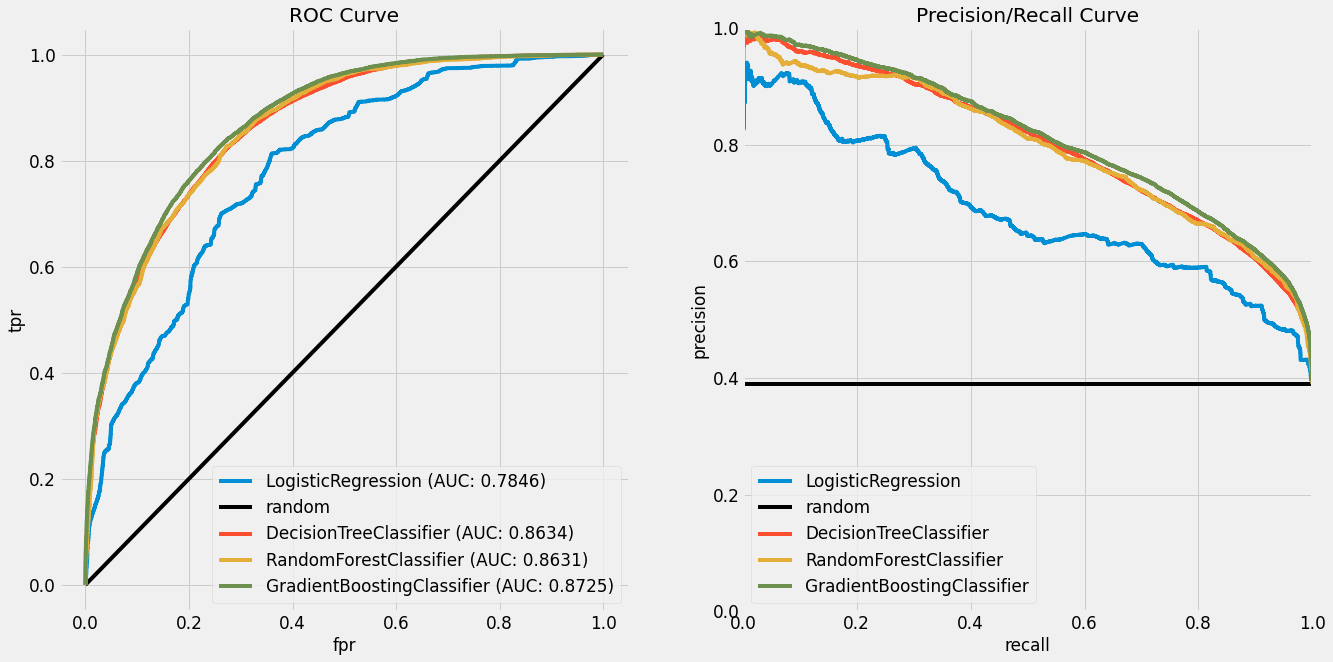

In [203]:
#ROC Curve
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10))
plot_roc(ax1, log_reg_df,log_reg,True)
plot_roc(ax1, dt_df,dt_model)
plot_roc(ax1, rf_df,rf_model)
plot_roc(ax1, gb_df,gb_model)


plot_precision_recall(ax2, log_reg_df,log_reg,True)
plot_precision_recall(ax2, dt_df,dt_model)
plot_precision_recall(ax2, rf_df,rf_model)
plot_precision_recall(ax2, gb_df,gb_model)

Text(0.5, 1.0, 'Confusion Matrix with Optimal Threshold')

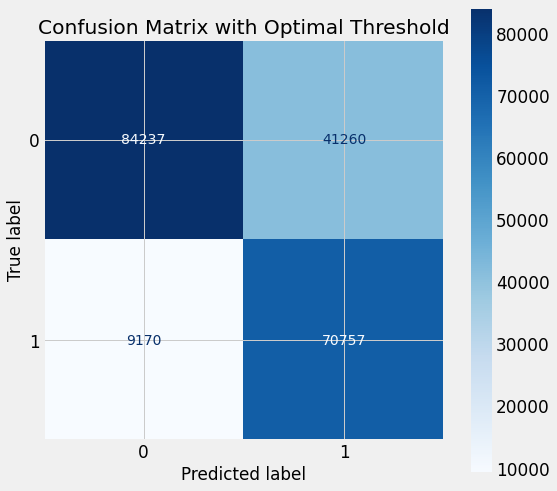

In [204]:
# How to identify proper threshold?
cm = confusion_matrix1(gb_model, X,y, 0.32)

fig, ax = plt.subplots(figsize = (8,8))

disp = ConfusionMatrixDisplay(confusion_matrix=cm.to_numpy())
disp.plot(cmap = plt.cm.Blues, ax = ax)
ax.set_title('Confusion Matrix with Optimal Threshold')

In [280]:
cities = df.groupby(['Division','Theatre','Area'],as_index=False).last()
cities = cities[cities['Division'] != 'CANADIAN']
cities = cities.groupby(['Theatre','Area'],as_index=False).first()[['Theatre','Area']]
cities

,Theatre,Area
0,About Archive Forum,DURHAM
1,About Bevy Flicks,"PERRY, IA"
2,About Bold Forum,"PASSAIC COUNTY, NJ"
3,About Crypt Flicks,"MILAN, TN"
4,About Discover Cinemas,"LOS ANGELES, CA"
...,...,...
5704,for Promotions Flicks,"MIAMI, FL"
5705,for Pure Cinemas,"HASTINGS, MI"
5706,for Radical Theaters,"GREENSBURG, IN"
5707,for Ratchet Marquee,"INDIANAPOLIS, IN"


In [284]:
cities_list = cities['Area'].unique().tolist()
cities_list
cities_dict = dict.fromkeys(cities_list)


In [251]:
import geopandas as gpd
from shapely.geometry import Point, Polygon
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

from geopy.geocoders import Nominatim

In [237]:
usa = gpd.read_file("data/States_shapefile.shp")

<AxesSubplot:>

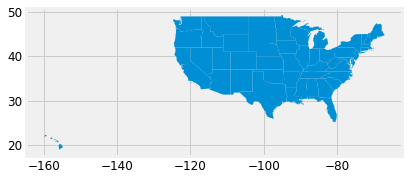

In [249]:
usa.drop(,axis=0).plot()

In [ ]:
from geopy import geocoders

geolocator = Nominatim(user_agent="over_under_theatres.ipynb")
lat=[]
long=[]

def findGeocode(city):
       
    # try and catch is used to overcome
    # the exception thrown by geolocator
    # using geocodertimedout  
    try:
          
        # Specify the user_agent as your
        # app name it should not be none
        geolocator = Nominatim(user_agent="your_app_name")
          
        return geolocator.geocode(city)
      
    except GeocoderTimedOut:
          
        return findGeocode(city)    


for key,value in tqdm(cities_dict.items()):
    if findGeocode(city) != None:
           
        loc = findGeocode(city)
          
        # coordinates returned from 
        # function is stored into
        # two separate list
        cities_dict[key] = (loc.latitude, loc.longitude)
       
    # if coordinate for a city not
    # found, insert "NaN" indicating 
    # missing value 
    else:
        cities_dict[key] = (np.nan, np.nan)
        
        
    #usa.plot(x,y,marker='o',color='Red',markersize=int(math.sqrt(count))*scale)
#plt.show()

In [ ]:
cities['lat']=lat

# EDA

In [ ]:
ax = df.groupby(['Division'])['T_No'].mean().plot.bar()
for p in ax.patches:
    ax.annotate((round(p.get_height(),3)), (p.get_x()+p.get_width()/3., p.get_height()*1.005),fontsize='large')
ax.set_title('Average Number of Playweeks by Division')

In [ ]:
def plot_hist_mean(grouped,target,bins=10):
    plot = df.groupby(grouped)[target].mean()
    fig,ax = plt.subplots()
    ax.hist(avg_bo,bins=bins); 

In [ ]:
plot_hist_mean('Division','Boxoffice',bins=50)

In [ ]:
avg_bo = df.groupby('City')['Boxoffice'].mean()
fig,ax = plt.subplots()
ax.hist(avg_bo,bins=10);


In [ ]:
avg_bo_adm = df.groupby('Theatre')[['Boxoffice','Admissions']].mean().sort_values(by='Boxoffice',ascending=False)
avg_bo_adm

In [ ]:
fig,ax = plt.subplots()
%time ax.scatter(avg_bo_adm.Admissions, avg_bo_adm.Boxoffice, alpha=0.5)
ax.set_title('Distribution of Avg Theatre Boxoffice')
ax.set_xlim(0,4000)
ax.set_ylabel('Average Boxoffice')
ax.set_xlabel('Average Admissions')
fig.tight_layout()

In [ ]:
avg_theatre.sort_values(by='Boxoffice',ascending=False).head(10)

In [ ]:
avg_theatre.sort_values(by='Boxoffice',ascending=True).head(10)

In [ ]:
df.groupby('Release')['Boxoffice'].mean().sort_values(ascending=True).tail(10).plot.barh(figsize=(10,7))
plt.xlabel('Average Location Gross')
plt.title('Top 10 Films by Avg Loc Gross')

# Clustering Data

In [ ]:
import itertools
import scipy.stats as stats
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [ ]:
def plot_elbow_sil(df,maxk):
    maxk = maxk
    wcss = []
    sil_scores = []
    for i in tqdm(range(2, maxk)):
        kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=100, n_init=10, random_state=0)
        kmeans.fit(df)
        ypred=kmeans.predict(df)
        wcss.append(kmeans.inertia_)    
        labels = kmeans.labels_
        
        score = silhouette_score(df, labels, metric = 'euclidean')
        sil_scores.append(score)
    plt.plot(range(2, maxk), wcss)
    plt.title('Elbow Method')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()

    # Plot Plots
    fig, ax = plt.subplots(figsize=(maxk,10))
    ax.plot(range(2,maxk), sil_scores, 'o-')
    ax.set_xlabel("Number of clusters")
    ax.set_ylabel("Silhouette score")

In [ ]:
fm = full_movie.copy()
fm.set_index('TITLE',inplace=True)
num_cols = fm.columns[fm.dtypes.apply(lambda x: np.issubdtype(x, np.number))]
scale = StandardScaler()
fm[num_cols]=scale.fit_transform(fm[num_cols])
fm_1hot = pd.get_dummies(fm[['Genre','Season','Rating']],drop_first = True)
fm_1hot
fm_full = fm.join(fm_1hot,how='left')
fm_full = fm_full.drop(['Genre','Season','Rating'],axis=1)
fm_full

In [ ]:
plot_elbow_sil(fm_full,20)

In [ ]:
#Genre + Movie Clustering
fm_cluster = KMeans(n_clusters=5, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = fm_cluster.fit_predict(fm_full)
fm_full['clusters']=pred_y

cluster_test = fm_full['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

In [ ]:
fm_num = fm.drop(['Genre','Season','Rating'],axis=1)

fm_std = (fm_num-np.mean(fm_num))/np.std(fm_num)
n_components = 2
fm_pca = PCA(n_components=n_components).fit_transform(fm_std.values)
fm_pca

In [ ]:
plot_elbow_sil(fm_pca,20)

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.scatter(fm_pca[:, 0], fm_pca[:, 1])
ax.set_title("Scatterplot of Movie Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

In [ ]:
#Movie_PCA Clustering

fm_pca_df = pd.DataFrame(fm_pca, columns = ('PCA1','PCA2'))
fm_pca_df = fm_pca_df.join(fm,how='right')

fmpca_cluster = KMeans(n_clusters=17, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = fmpca_cluster.fit_predict(fm_pca)
fm_pca_df['clusters']=pred_y

cluster_test = fm_pca_df['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

In [ ]:
fm_nobo = fm_full.drop(['# of Runs','Boxoffice_Total','OW to YT','clusters'],axis=1)
plot_elbow_sil(fm_nobo,40)

In [ ]:
#No BO Clustering

nobo_cluster = KMeans(n_clusters=28, init='k-means++', max_iter=500, n_init=10, random_state=0)
pred_y = nobo_cluster.fit_predict(fm_nobo)
fm_nobo['clusters']=pred_y

cluster_test = fm_nobo['clusters']
with pd.option_context("display.max_rows", 1000):
    display(cluster_test.sort_values())

# NLP on Plot Overview

In [ ]:
import string
import unicodedata

import nltk

from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk import pos_tag
from nltk import RegexpParser



def extract_bow_from_raw_text(text_as_string):
    """Extracts bag-of-words from a raw text string.

    Parameters
    ----------
    text (str): a text document given as a string

    Returns
    -------
    list : the list of the tokens extracted and filtered from the text
    """
    if (text_as_string == None):
        return []

    if (len(text_as_string) < 1):
        return []

    nfkd_form = unicodedata.normalize('NFKD', text_as_string)
    text_input = str(nfkd_form.encode('ASCII', 'ignore'))

    sent_tokens = sent_tokenize(text_input)

    tokens = list(map(word_tokenize, sent_tokens))

    sent_tags = list(map(pos_tag, tokens))

    grammar = r"""
        SENT: {<(J|N).*>}                # chunk sequences of proper nouns
    """

    cp = RegexpParser(grammar)
    ret_tokens = list()
    #lemmatizer = WordNetLemmatizer()
    stemmer_snowball = SnowballStemmer('english')

    for sent in sent_tags:
        tree = cp.parse(sent)
        for subtree in tree.subtrees():
            if subtree.label() == 'SENT':
                t_tokenlist = [tpos[0].lower() for tpos in subtree.leaves()]
                #t_tokens_lemma = list(map(lemmatizer.lemmatize, t_tokenlist))
                t_tokens_stemsnowball = list(map(stemmer_snowball.stem, t_tokenlist))
    
                ret_tokens.extend(t_tokens_stemsnowball)

    return(ret_tokens)
    

In [ ]:
movie_text

In [ ]:
docs = []
for desc in tqdm(movie_text):
    docs.append(desc)

In [ ]:
# extracting bows
bows = list(map(lambda row: extract_bow_from_raw_text(row), docs))

In [ ]:
# displaying bows
for i in range(len(docs)):
    print("\n--- Plot: {}".format(docs[i]))
    print("--- BoW: {}".format(bows[i]))

In [ ]:
from collections import Counter

# term occurence = counting distinct words in each bag
term_occ = list(map(lambda bow : Counter(bow), bows))

# term frequency = occurences over length of bag
term_freq = list()
for i in range(len(docs)):
    term_freq.append( {k: (v / float(len(bows[i])))
                       for k, v in term_occ[i].items()} )

# displaying occurences
for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]))
    print("--- bow: {}".format(bows[i]))
    print("--- term_occ: {}".format(term_occ[i]))
    print("--- term_freq: {}".format(term_freq[i]))

In [ ]:
# document occurence = number of documents having this word
# term frequency = occurences over length of bag

doc_occ = Counter( [word for bow in bows for word in set(bow)] )

# document frequency = occurences over length of corpus
doc_freq = {k: (v / float(len(docs)))
            for k, v in doc_occ.items()}

# displaying vocabulary
print("\n--- full vocabulary: {}".format(doc_occ))
print("\n--- doc freq: {}".format(doc_freq))

In [ ]:
# the minimum document frequency (in proportion of the length of the corpus)
min_df = 0.04

# filtering items to obtain the vocabulary
vocabulary = [ k for k,v in doc_freq.items() if v >= min_df ]

# print vocabulary
print ("-- vocabulary (len={}): {}".format(len(vocabulary),sorted(vocabulary)))

In [ ]:
import numpy as np

# create a dense matrix of vectors for each document
# each vector has the length of the vocabulary
vectors = np.zeros((len(docs),len(vocabulary)))

# fill these vectors with tf-idf values
for i in range(len(docs)):
    for j in range(len(vocabulary)):
        term     = vocabulary[j]
        term_tf  = term_freq[i].get(term, 0.0)   # 0.0 if term not found in doc
        term_idf = np.log(1 + 1 / doc_freq[term]) # smooth formula
        vectors[i,j] = term_tf * term_idf

# displaying results
'''for i in range(len(docs)):
    print("\n--- review: {}".format(docs[i]))
    print("--- bow: {}".format(bows[i]))
    print("--- tfidf vector: {}".format( vectors[i] ) )
    print("--- tfidf sorted: {}".format( 
            sorted( zip(vocabulary,vectors[i]), key=lambda x:-x[1] )
         ))
         '''

In [ ]:
mv_tfidf = pd.DataFrame(data=vectors,columns=sorted(vocabulary))
mv_tfidf = mv_tfidf.rename(columns={"b'in":'in',"b'the":'the',"b'when":'when'})
mv_tfidf.drop('b',axis=1,inplace=True)

mv_tfidf

# Sklearn TFIDF

In [ ]:
corpus = [row for row in docs]
from sklearn.feature_extraction.text import CountVectorizer

tf = CountVectorizer(stop_words='english')

document_tf_matrix = tf.fit_transform(corpus).todense()

sorted(tf.vocabulary_);
document_tf_matrix;

from math import log

def idf(frequency_matrix):
    df =  float(len(document_tf_matrix)) / sum(frequency_matrix > 0)
    return [log(i) for i in df.getA()[0]]
sorted(tf.vocabulary_);
idf(document_tf_matrix);

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(stop_words='english')
document_tfidf_matrix = tfidf.fit_transform(corpus)
#print(tfidf.vocabulary_)
print(document_tfidf_matrix.todense())

# PCA

In [ ]:
from sklearn.decomposition import PCA
mv_tfidf_std = (mv_tfidf-np.mean(mv_tfidf))/np.std(mv_tfidf)
n_components = 2
mv_tfidf_pca = PCA(n_components=n_components).fit_transform(mv_tfidf_std.values)
#mv_tf_pca = movies_tfidf_std.values @ pca.components_.T
mv_tfidf_pca

In [ ]:
fig, ax = plt.subplots(1, figsize=(8, 8))

ax.scatter(mv_tfidf_pca[:, 0], mv_tfidf_pca[:, 1])
ax.set_title("Scatterplot of Movie Data in PCA 2-Plane")
ax.set_xlabel("First Principal Component")
ax.set_ylabel("Second Principal Component")

In [ ]:
plot_elbow_sil(mv_tfidf_pca,20)

In [ ]:
with pd.option_context("display.max_rows", 1000):
    display(genre_df['TITLE'])

In [ ]:
#Movie Clustering + Genre DF for title
pca_cluster = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = pca_cluster.fit_predict(mv_tfidf_pca)

mv_pca = pd.DataFrame(mv_tfidf_pca, columns = ('PCA1','PCA2'))
mv_pca = mv_pca.join(genre_df['TITLE'],how='left')
mv_pca.set_index('TITLE',inplace=True)
mv_pca['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca['clusters']

with pd.option_context("display.max_rows", 1000):
    display(tfidf_cluster_.sort_values())

In [ ]:
# Text PCA + No Boxoffice Dataframe 
mv_pca_full = mv_pca.join(fm_nobo,how='left',rsuffix='_x')
mv_pca_full.drop(['clusters','clusters_x'],axis=1,inplace=True)


#scale = StandardScaler()
#runtime = mv_pca_full['ow_by_runtime']
#transform = scale.fit_transform(runtime.values.reshape(-1,1))
#mv_pca_full['ow_by_runtime']= transform

mv_pca_full

In [ ]:
with pd.option_context("display.max_rows", 1000):
    display(mv_pca_full)

In [ ]:
plot_elbow_sil(mv_pca_full,20)

In [ ]:
#Movie Clustering
tfidf_cluster = KMeans(n_clusters=7, init='k-means++', max_iter=1000, n_init=10, random_state=0)
pred_y_tfidf = tfidf_cluster.fit_predict(mv_pca_full)
mv_pca_full['clusters']=pred_y_tfidf
tfidf_cluster_ = mv_pca_full['clusters']
with pd.option_context("display.max_rows", 1000):
    display(tfidf_cluster_.sort_values())